In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
df=pd.read_csv('TRADES_CopyTr_90D_ROI.csv')


In [22]:
df.head()

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Port_IDs       150 non-null    int64 
 1   Trade_History  149 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [24]:
df.shape

(150, 2)

In [25]:
df.isnull().sum()

Port_IDs         0
Trade_History    1
dtype: int64

In [26]:
df=df.drop(columns=['Trade_History'],axis=1)

In [27]:
df.isnull().sum()

Port_IDs    0
dtype: int64

In [28]:
df.describe()

,Port_IDs
count,1.500000e+02
mean,3.975655e+18
std,6.887470e+16
min,3.672755e+18
25%,3.943672e+18
50%,3.998616e+18
75%,4.029508e+18
max,4.041860e+18


In [29]:
df.fillna(0,inplace=True)

In [30]:
df.head()

,Port_IDs
0,3925368433214965504
1,4002413037164645377
2,3923766029921022977
3,3994879592543698688
4,3926423286576838657


In [31]:



import numpy as np
import pandas as pd

def calculate_metrics(df):
    # Check if necessary columns exist before calculations
    required_columns = ['realizedProfit', 'quantity', 'std_dev', 'max_drawdown', 'side']
    
    missing_columns = [col for col in required_columns if col not in df.columns]
    
    if missing_columns:
        raise KeyError(f"Missing required columns: {', '.join(missing_columns)}")
    
    # Calculate ROI
    df['ROI'] = np.where(df['quantity'] != 0, (df['realizedProfit'] / df['quantity']) * 100, 0)
    
    # Profit and Loss (PnL)
    df['PnL'] = df['realizedProfit']
    
    # Sharpe Ratio, protect against division by zero
    df['Sharpe Ratio'] = np.where(df['std_dev'] != 0, df['ROI'] / df['std_dev'], 0)
    
    # Maximum Drawdown (MDD)
    df['MDD'] = df['max_drawdown']
    
    # Win Rate (1 for profit, 0 for loss)
    df['Win Rate'] = np.where(df['realizedProfit'] > 0, 1, 0)
    
    # Count win positions for BUY trades only
    df['Win Positions'] = np.where((df['side'] == 'BUY') & (df['realizedProfit'] > 0), 1, 0)
    
    # Total Positions count (assumed to be 1 per row)
    df['Total Positions'] = 1
    
    return df

# Example usage:
data = {
    'realizedProfit': [100, 200, -50],
    'quantity': [10, 20, 5],
    'std_dev': [1, 2, 0.5],
    'max_drawdown': [50, 100, 20],
    'side': ['BUY', 'SELL', 'BUY']
}

df = pd.DataFrame(data)

try:
    df = calculate_metrics(df)
    print(df)
except KeyError as e:
    print(e)


   realizedProfit  quantity  std_dev  max_drawdown  side     ROI  PnL  \
0             100        10      1.0            50   BUY  1000.0  100   
1             200        20      2.0           100  SELL  1000.0  200   
2             -50         5      0.5            20   BUY -1000.0  -50   

   Sharpe Ratio  MDD  Win Rate  Win Positions  Total Positions  
0        1000.0   50         1              1                1  
1         500.0  100         1              0                1  
2       -2000.0   20         0              0                1  


In [32]:

import pandas as pd
# Print existing columns
print(df.columns)

# Check if 'Port_ID' exists
if 'Port_ID' not in df.columns:
    # Assign a default value
    df['Port_ID'] = 'Default_Port_ID'

# Ensure required columns exist
required_columns = ['Port_ID', 'ROI', 'PnL', 'Sharpe Ratio', 'MDD', 'Win Rate', 'Win Positions', 'Total Positions']
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    raise KeyError(f"Missing required columns: {', '.join(missing_columns)}")

# Group by 'Port_ID' and calculate metrics
metrics_df = df.groupby('Port_ID').agg({
    'ROI': 'mean',
    'PnL': 'sum',
    'Sharpe Ratio': 'mean',
    'MDD': 'max',
    'Win Rate': 'mean',
    'Win Positions': 'sum',
    'Total Positions': 'sum'
}).reset_index()

print(metrics_df)

Index(['realizedProfit', 'quantity', 'std_dev', 'max_drawdown', 'side', 'ROI',
       'PnL', 'Sharpe Ratio', 'MDD', 'Win Rate', 'Win Positions',
       'Total Positions'],
      dtype='object')
           Port_ID         ROI  PnL  Sharpe Ratio  MDD  Win Rate  \
0  Default_Port_ID  333.333333  250   -166.666667  100  0.666667   

   Win Positions  Total Positions  
0              1                3  


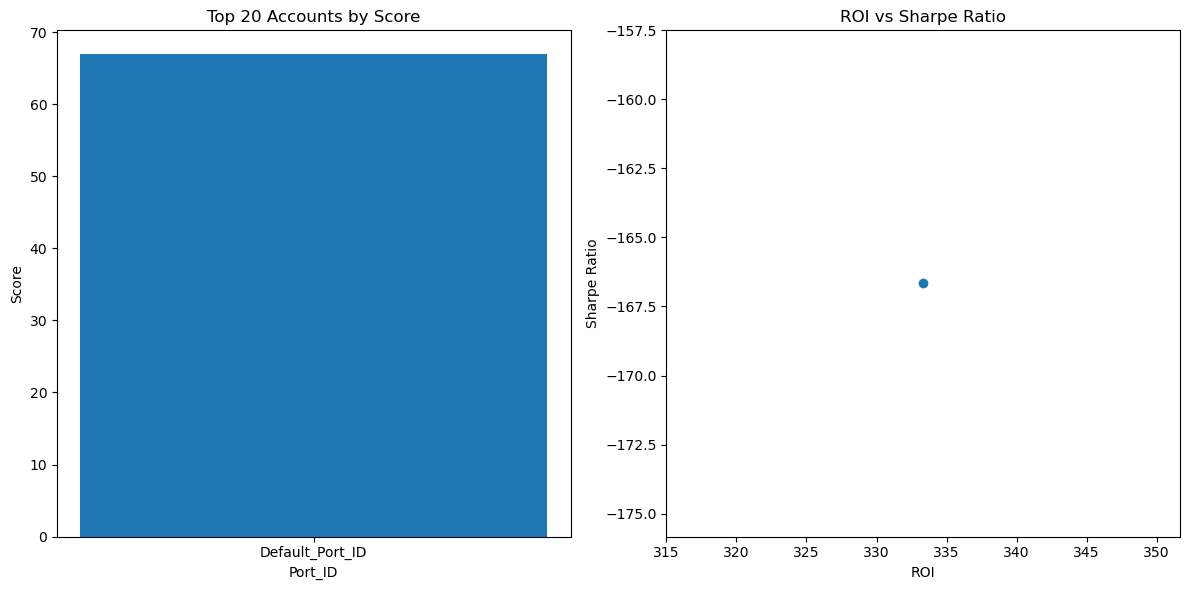

In [37]:

# Ranking Algorithm Weights
weights = {
    'ROI': 0.3,
    'Sharpe Ratio': 0.2,
    'Win Rate': 0.2,
    'Win Positions Ratio': 0.3
}

# Group by Port_ID and calculate metrics
metrics_df = df.groupby('Port_ID').agg({
    'ROI': 'mean',
    'PnL': 'sum',
    'Sharpe Ratio': 'mean',
    'MDD': 'max',
    'Win Rate': 'mean',
    'Win Positions': 'sum',
    'Total Positions': 'sum'
}).reset_index()

# Calculate Score
metrics_df['Score'] = (
    metrics_df['ROI'] * weights['ROI'] +
    metrics_df['Sharpe Ratio'] * weights['Sharpe Ratio'] +
    metrics_df['Win Rate'] * weights['Win Rate'] +
    (metrics_df['Win Positions'] / metrics_df['Total Positions']) * weights['Win Positions Ratio']
)
# Rank accounts
ranked_df = metrics_df.sort_values('Score', ascending=False).head(20)
# Data Visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(ranked_df['Port_ID'], ranked_df['Score'])
plt.xlabel('Port_ID')
plt.ylabel('Score')
plt.title('Top 20 Accounts by Score')

plt.subplot(1, 2, 2)
plt.scatter(ranked_df['ROI'], ranked_df['Sharpe Ratio'])
plt.xlabel('ROI')
plt.ylabel('Sharpe Ratio')
plt.title('ROI vs Sharpe Ratio')

plt.tight_layout()
plt.show()
# Save deliverables
ranked_df.to_csv('top_20_accounts.csv', index=False)
metrics_df.to_csv('calculated_metrics.csv', index=False)
# Generate report
with open('report.txt', 'w') as f:
    f.write('Methodology:\n')
    f.write('1. Data Exploration and Cleaning\n')
    f.write('2. Feature Engineering\n')
    f.write('3. Ranking Algorithm\n\n')
    
    f.write('Findings:\n')
    f.write('Top 20 accounts based on ranking:\n')
    f.write(ranked_df.to_string())
    f.write('\n\nAssumptions:\n')
    f.write('1. Missing values replaced with 0.\n')
    f.write('2. Weights assigned to metrics based on importance.\n')
